# RNN Examples

An alternative to VAEs for generating STL objects is an RNN or LSTM. The thought is that RNNs generate data sequentially, and this might improve the connectedness of our STL triangles. In other words, an RNN will generate triangle 2 based on triangle 1's vertices whereas a VAE generates each singularly.

## I. Andrej Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks

From https://www.tensorflow.org/tutorials/sequences/text_generation

Uses an RNN to generate Shakespeare-esque text on the character level (not whole words).

### I. A. Setup

In [1]:
# setup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

### I. B. Download Data

In [2]:
# download data
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


### I. C. Process Text

In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  'C' :  15,
  ' ' :   1,
  '$' :   3,
  'I' :  21,
  ':' :  10,
  'Z' :  38,
  'G' :  19,
  'r' :  56,
  'p' :  54,
  'f' :  44,
  'i' :  47,
  'B' :  14,
  't' :  58,
  'V' :  34,
  'N' :  26,
  'R' :  30,
  '-' :   7,
  'x' :  62,
  'X' :  36,
  'U' :  33,
  ...
}


In [8]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### I. D. Create Training Examples

In [9]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [57]:
def split_input_target(chunk):
    print(chunk.shape)
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
dataset

(101,)


<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [12]:
for input_example, target_example in dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [13]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


### I. E. Create Training Batches

In [14]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build the Model

In [15]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [39]:
if tf.test.is_gpu_available():
    rnn = tf.keras.layers.CuDNNGRU
else:
    import functools
    rnn = functools.partial(
      tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [52]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                  batch_input_shape=[batch_size, None]),
        rnn(rnn_units,
            return_sequences=True, 
            recurrent_initializer='glorot_uniform',
            stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [53]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

In [54]:
for input_example_batch, target_example_batch in dataset.take(1): 
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3935232   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,018,497
Trainable params: 4,018,497
Non-trainable params: 0
_________________________________________________________________


In [31]:
# changed categorical to multinomial according to https://github.com/tensorflow/tensorflow/issues/24949
#sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [32]:
sampled_indices

array([43, 44, 56, 50, 39, 43,  1,  0, 41, 39, 61, 56, 41,  1, 46, 39, 42,
        1,  1, 54,  1, 56, 49, 51, 24, 43, 35, 43,  8, 58, 53, 58, 39, 57,
       59, 56, 41, 43, 58, 39, 46, 43,  6, 57, 39, 34, 43, 57,  1,  1,  1,
       50,  1,  1, 57,  1, 47, 39, 46, 52,  1, 43, 58, 57, 59, 53, 43, 19,
       56, 30, 58, 41, 59, 57, 53, 57,  5, 44, 39, 58, 41, 58, 58, 43, 58,
       56, 58, 51, 50, 44, 40,  1, 58, 43, 59,  0,  1,  1, 50, 57])

In [33]:
# untrained model - low expectations
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 "time heard lions roar?\nHave I not heard the sea puff'd up with winds\nRage like an angry boar chafed "

Next Char Predictions: 
 "efrlae \ncawrc had  p rkmLeWe.totasurcetahe,saVes   l  s iahn etsuoeGrRtcusos'fatcttetrtmlfb teu\n  ls"


### I. F. Optimizer & Loss

In [34]:
def loss(labels, logits):
    # changed to backend thanks to the kind folks at https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/python/keras/losses.py
    #return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       2.8963306


In [35]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

### I. G. Configure Checkpoints

In [36]:
# Directory where the checkpoints will be saved
checkpoint_dir = './_output/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### I. H. Train

In [37]:
EPOCHS=3

In [38]:
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/3
174/174 [==============================] - 397s 2s/step - loss: 2.1839
Epoch 2/3
174/174 [==============================] - 396s 2s/step - loss: 1.7289
Epoch 3/3
174/174 [==============================] - 396s 2s/step - loss: 1.5371


### I. I. Generate Text

In [40]:
tf.train.latest_checkpoint(checkpoint_dir)
checkpoint_dir

'./_output/training_checkpoints'

In [41]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3935232   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,018,497
Trainable params: 4,018,497
Non-trainable params: 0
_________________________________________________________________


In [44]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing) 
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
      
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [45]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: go dost I so, were that?

SAMPSOG:
The norst intently wholuny;
Fau, you appaired, who?

MENENIUS:
The presset my lebst:
Veater words not for Furlo, and now for me, night, hose
Wonder's naturn hither fither call our ghart cau
Wo she would not
Extone endroation, in the is fall'd with a do
Answle vere in his heart.

LEONTES:
Alas! I have, for my liverd;
I have you fush any that I am hows but door
Can can be rique'dlease of his land:
The foot of whice: I am,.

Pitizens:
Sweet arms, I surply to see. What's wishes in distransmen forgot:
We thank you genlet him's son.

PETRUCHIO:
'Tis tomens of guttlemen and wlitted thee with what
I fiald should root Peasen call for thy socrep of like
And Croble in Edward Beholding some, and so father;
Trumsful by thee instarter.
And if you will.

FERDI VONGENThey health, out doth kill do his father
Now wixes my be a capoler, where is it break do proy her son.

MENENIUS:
The father Praming rame
To the Bosh; gentleme:
For it is like law, E wnock fos lon

### I. J. Advanced: Customized Training

In [46]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

In [47]:
optimizer = tf.train.AdamOptimizer()

In [48]:
# Training step
EPOCHS = 1

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch_n, (inp, target)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # feeding the hidden state back into the model
            # This is the interesting step
            predictions = model(inp)
            loss = tf.losses.sparse_softmax_cross_entropy(target, predictions)
              
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if batch_n % 100 == 0:
            template = 'Epoch {} Batch {} Loss {:.4f}'
            print(template.format(epoch+1, batch_n, loss))

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.1738
Epoch 1 Batch 100 Loss 2.3267
Epoch 1 Loss 2.1012
Time taken for 1 epoch 392.35351943969727 sec



### I. K. Tutorial Complete!

## II. Time-Series RNN/LSTM

From: https://medium.com/google-cloud/how-to-do-time-series-prediction-using-rnns-and-tensorflow-and-cloud-ml-engine-2ad2eeb189e8

Code: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/blogs/timeseries/rnn_cloudmle.ipynb

In [10]:
# import the tensorflow
import tensorflow as tf
print(tf.__version__)

1.12.0


/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


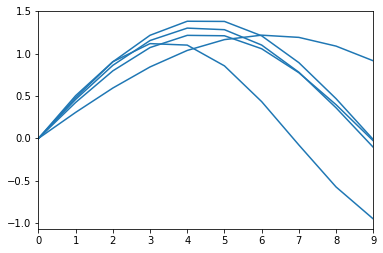

In [11]:
# generate some data to play with
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd

SEQ_LEN = 10
def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
    return x

for i in range(0, 5):
    sns.tsplot( create_time_series() );  # 5 series

In [7]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in range(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

to_csv('_output/train.csv', 1000)  # 1000 sequences
to_csv('_output/valid.csv',  50)

In [8]:
!head -5 train.csv valid.csv

==> train.csv <==
0.0,0.3213675206026848,0.6268411629522288,0.901313112568992,1.1312088061525831,1.3051582889611957,1.4145585388326278,1.4539989459794964,1.4215289055980835,1.3187542889591664
0.0,0.22982614526715603,0.4528559751627079,0.6624941518956339,0.8525413496174805,1.0173775780973462,1.152128374544617,1.2528089490296441,1.316442020898832,1.3411458615786787
0.0,0.22080532562816035,0.43065281579600434,0.6191284360481678,0.7768787669001846,0.8960751830035983,0.9708023618388778,0.9973518415391679,0.9744060595443933,0.9031037388581403
0.0,0.6811239929853302,1.1684264622429572,1.3232399873318275,1.101510631471846,0.5663339867292717,-0.12999938920632176,-0.789339970938316,-1.22406495039811,-1.3104684255926047
0.0,0.6306492001395932,1.0420546308084837,1.09119212360909,0.7609791401959103,0.16621347813318033,-0.48633592404162496,-0.9698117411039756,-1.1161346976703221,-0.8744359485084771

==> valid.csv <==
0.0,0.16757508043429512,0.32921560349130113,0.4791971801026031,0.6122083148499722,0

In [12]:
# import some more stuff
import tensorflow as tf
import shutil
from tensorflow.contrib.learn import ModeKeys
import tensorflow.contrib.rnn as rnn

In [14]:
# data import function
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS


# read data and convert to needed format
def read_dataset(filename, mode=ModeKeys.TRAIN):
    def _input_fn():
        num_epochs = 100 if mode == ModeKeys.TRAIN else 1

        # could be a path to one file or a file pattern.
        input_file_names = tf.train.match_filenames_once(filename)

        filename_queue = tf.train.string_input_producer(
            input_file_names, num_epochs=num_epochs, shuffle=True)
        reader = tf.TextLineReader()
        _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

        value_column = tf.expand_dims(value, -1, name='value')
        print('readcsv={}'.format(value_column))

        # all_data is a list of tensors
        all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
        inputs = all_data[:len(all_data)-N_OUTPUTS]  # first few values
        label = all_data[len(all_data)-N_OUTPUTS : ] # last few values

        # from list of tensors to tensor with one more dimension
        inputs = tf.concat(inputs, axis=1)
        label = tf.concat(label, axis=1)
        print('inputs={}'.format(inputs))

        return {TIMESERIES_COL: inputs}, label   # dict of features, label

    return _input_fn

In [18]:
# define the rnn
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, labels, mode, params):
    # 0. Reformat input shape to become a sequence
    x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    #print 'x={}'.format(x)

    # 1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
    outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    #print 'last outputs={}'.format(outputs)

    # output is result of linear activation of last layer of RNN
    weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
    bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
    predictions = tf.matmul(outputs, weight) + bias

    # 2. loss function, training/eval ops
    if mode == ModeKeys.TRAIN or mode == ModeKeys.EVAL:
        loss = tf.losses.mean_squared_error(labels, predictions)
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=0.01,
            optimizer="SGD")
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
        }
    else:
        loss = None
        train_op = None
        eval_metric_ops = None

    # 3. Create predictions
    predictions_dict = {"predicted": predictions}

    # 4. Create export outputs  
    export_outputs = {"predicted": tf.estimator.export.PredictOutput(predictions)}

    # 5. return ModelFnOps
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs=export_outputs)

In [19]:
# experimenting
def get_train():
    return read_dataset('train.csv', mode=ModeKeys.TRAIN)

def get_valid():
    return read_dataset('valid.csv', mode=ModeKeys.EVAL)

def serving_input_receiver_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }

    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }

    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2], name='timeseries')
  
    print('serving: features={}'.format(features[TIMESERIES_COL]))

    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)


def experiment_fn(output_dir):
    train_spec = tf.estimator.TrainSpec(input_fn=get_train(), max_steps=1000)
    exporter = tf.estimator.FinalExporter('timeseries',
    serving_input_receiver_fn)
    eval_spec = tf.estimator.EvalSpec(input_fn=get_valid(), 
        exporters=[exporter])

    estimator = tf.estimator.Estimator(model_fn=simple_rnn, model_dir=output_dir)

    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

OUTPUT_DIR = 'outputdir'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True) # start fresh each time

experiment_fn(OUTPUT_DIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_eval_distribute': None, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_evaluation_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_is_chief': True, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_id': 0, '_train_distribute': None, '_save_checkpoints_secs': 600, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa4e4c1aa90>, '_device_fn': None, '_tf_random_seed': None, '_experimental_distribute': None, '_save_summary_steps': 100, '_model_dir': 'outputdir', '_task_type': 'worker', '_master': '', '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start t